In [1]:
#############################################
#import 
#############################################
import os
import sys
import torch
import logging
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
import numpy as np
import math
__file__ = "perturnations.ipynb"
sys.path.append(os.path.join(os.path.dirname(__file__), '../'))
#from config.test_config import get_config_test
from models.pipeline_factory import get_pipeline
from models.pipelines.pipeline_utils import *

In [2]:
#############################################
#paramètres testés
#############################################

#perturbations
tremblement = False
rotation = True
occlusion = False

# nuage ID
query_idx = 3573

In [3]:
#############################################
#Fonctions
#############################################

def test_rotation(xyzr, r_angle=360):
    # Rotate about z-axis by fixed angle 'r_angle'.
    r_angle = (np.pi/180) * r_angle
    cos_angle = np.cos(r_angle)
    sin_angle = np.sin(r_angle)
    rot_matrix = np.array([[cos_angle, -sin_angle, 0],
                           [sin_angle, cos_angle, 0],
                           [0,             0,      1]])
    scan = xyzr[:, :3]
    #print("pcd_data.py: xyzr shape",np.shape(xyzr),xyzr[0])
    int = xyzr[:, 3].reshape((-1, 1))
    augmented_scan = np.dot(scan, rot_matrix)
    augmented_scan = np.hstack((augmented_scan, int))
    return augmented_scan.astype(np.float32)

def test_bruit(xyzr, n_sigma = 0.01):
    scan = xyzr[:, :3]
    #print("pcd_data.py: xyzr shape",np.shape(xyzr),xyzr[0])
    int = xyzr[:, 3].reshape((-1, 1))
    r_angle = (np.pi/180) * 360
    cos_angle = np.cos(r_angle)
    sin_angle = np.sin(r_angle)
    rot_matrix = np.array([[cos_angle, -sin_angle, 0],
                           [sin_angle, cos_angle, 0],
                           [0,             0,      1]])
    augmented_scan = np.dot(scan, rot_matrix)

    # Add gaussian noise
    noise = np.clip(n_sigma * np.random.randn(*
                    augmented_scan.shape), -3*n_sigma, 3*n_sigma)
    augmented_scan = augmented_scan + noise

    augmented_scan = np.hstack((augmented_scan, int))
    return augmented_scan.astype(np.float32)

def occlude_scan(xyzr, angle=30):
    # Remove points within a sector of fixed angle (degrees) and random heading direction.
    thetas = (180/np.pi) * np.arctan2(xyzr[:, 1], xyzr[:, 0])
    heading = (180-angle/2)*np.random.uniform(-1, 1)
    occ_scan = np.vstack(
        (xyzr[thetas < (heading - angle/2)], xyzr[thetas > (heading + angle/2)]))
    return occ_scan.astype(np.float32)

In [4]:
import argparse

arg_lists = []
parser = argparse.ArgumentParser()


def add_argument_group(name):
    arg = parser.add_argument_group(name)
    arg_lists.append(arg)
    return arg

def str2bool(v):
    return v.lower() in ('true', '1')

# Evaluation
test_arg = add_argument_group('Eval')
test_arg.add_argument('--eval_pipeline', type=str, default='LOGG3D')
#test_arg.add_argument('--eval_pipeline', type=str, default='PointNetVLAD')
test_arg.add_argument('--kitti_eval_seq', type=int, default=6)
test_arg.add_argument('--mulran_eval_seq', type=str,default='DCC/DCC_02')
#test_arg.add_argument('--checkpoint_name', type=str,default='/kitti_10cm_loo/2021-09-14_20-28-22_3n24h_Kitti_v10_q29_10s8_263169.pth')

#test_arg.add_argument('--checkpoint_name', type=str,default='/logg_epoc_10_kit_check')

test_arg.add_argument('--checkpoint_name', type=str,default='/logg_epoc_31_mulran')

test_arg.add_argument('--eval_batch_size', type=int, default=1)
test_arg.add_argument('--test_num_workers', type=int, default=3)
test_arg.add_argument("--eval_random_rotation", type=str2bool,default=False, help="If random rotation. ")
test_arg.add_argument("--eval_random_occlusion", type=str2bool,default=False, help="If random occlusion. ")

test_arg.add_argument("--revisit_criteria", default=3,
                      type=float, help="in meters")
test_arg.add_argument("--not_revisit_criteria",
                      default=20, type=float, help="in meters")

test_arg.add_argument("--skip_time", default=30, type=float, help="in seconds")
test_arg.add_argument("--cd_thresh_min", default=0.001,
                      type=float, help="Thresholds on cosine-distance to top-1.")

test_arg.add_argument("--cd_thresh_max", default=1.0,
                      type=float, help="Thresholds on cosine-distance to top-1.")

test_arg.add_argument("--num_thresholds", default=1000, type=int,
                      help="Number of thresholds. Number of points on PR curve.")


# Dataset specific configurations
data_arg = add_argument_group('Data')
# KittiDataset #MulRanDataset
#data_arg.add_argument('--eval_dataset', type=str, default='KittiDataset')
data_arg.add_argument('--eval_dataset', type=str, default='MulRanDataset')
data_arg.add_argument('--collation_type', type=str,
                      default='default')  # default#sparcify_list
data_arg.add_argument("--eval_save_descriptors", type=str2bool, default=False)
data_arg.add_argument("--eval_save_counts", type=str2bool, default=False)
data_arg.add_argument("--eval_plot_pr_curve", type=str2bool, default=True)
data_arg.add_argument('--num_points', type=int, default=80000)
data_arg.add_argument('--voxel_size', type=float, default=0.10)
data_arg.add_argument("--gp_rem", type=str2bool,
                      default=False, help="Remove ground plane.")
data_arg.add_argument('--eval_feature_distance', type=str,
                      default='cosine')  # cosine#euclidean
data_arg.add_argument("--pnv_preprocessing", type=str2bool,
                      default=False, help="Preprocessing in dataloader for PNV.")

data_arg.add_argument('--kitti_dir', type=str, default='/gpfswork/rech/dki/ujo91el/datas/dataset/',help="Path to the KITTI odometry dataset")
data_arg.add_argument('--kitti_data_split', type=dict, default={
    'train': [0, 1, 2, 3, 4, 5, 6, 7, 9, 10],
    'val': [],
    'test': [8]
})

data_arg.add_argument('--mulran_dir', type=str,default='/gpfswork/rech/dki/ujo91el/datas/mulran/', help="Path to the MulRan dataset")

data_arg.add_argument("--mulran_normalize_intensity", type=str2bool,default=False, help="Normalize intensity return.")

data_arg.add_argument('--mulran_data_split', type=dict, default={
    'train': ['DCC/DCC_01', 'DCC/DCC_02',
              'Riverside/Riverside_01', 'Riverside/Riverside_03'],
    'val': [],
    'test': ['KAIST/KAIST_01']
})

# Data loader configs
data_arg.add_argument('--train_phase', type=str, default="train")
data_arg.add_argument('--val_phase', type=str, default="val")
data_arg.add_argument('--test_phase', type=str, default="test")
data_arg.add_argument('--use_random_rotation', type=str2bool, default=True)
data_arg.add_argument('--rotation_range', type=float, default=360)
data_arg.add_argument('--use_random_occlusion', type=str2bool, default=True)
data_arg.add_argument('--occlusion_angle', type=float, default=30)
data_arg.add_argument('--use_random_scale', type=str2bool, default=False)
data_arg.add_argument('--min_scale', type=float, default=0.8)
data_arg.add_argument('--max_scale', type=float, default=1.2)

def get_config_test():
    #args = parser.parse_args()
    args, unknown = parser.parse_known_args()
    return args

if __name__ == "__main__":
    cfg = get_config_test()
    dconfig = vars(cfg)
    print(dconfig)

{'eval_pipeline': 'LOGG3D', 'kitti_eval_seq': 6, 'mulran_eval_seq': 'DCC/DCC_02', 'checkpoint_name': '/logg_epoc_31_mulran', 'eval_batch_size': 1, 'test_num_workers': 3, 'eval_random_rotation': False, 'eval_random_occlusion': False, 'revisit_criteria': 3, 'not_revisit_criteria': 20, 'skip_time': 30, 'cd_thresh_min': 0.001, 'cd_thresh_max': 1.0, 'num_thresholds': 1000, 'eval_dataset': 'MulRanDataset', 'collation_type': 'default', 'eval_save_descriptors': False, 'eval_save_counts': False, 'eval_plot_pr_curve': True, 'num_points': 80000, 'voxel_size': 0.1, 'gp_rem': False, 'eval_feature_distance': 'cosine', 'pnv_preprocessing': False, 'kitti_dir': '/gpfswork/rech/dki/ujo91el/datas/dataset/', 'kitti_data_split': {'train': [0, 1, 2, 3, 4, 5, 6, 7, 9, 10], 'val': [], 'test': [8]}, 'mulran_dir': '/gpfswork/rech/dki/ujo91el/datas/mulran/', 'mulran_normalize_intensity': False, 'mulran_data_split': {'train': ['DCC/DCC_01', 'DCC/DCC_02', 'Riverside/Riverside_01', 'Riverside/Riverside_03'], 'val':

In [5]:
#############################################
#dataloading
#############################################

# Get config
cfg = get_config_test()
print("cfg.eval_dataset",cfg.eval_dataset)
if 'Kitti' in cfg.eval_dataset:
    print("cfg.kitti_eval_seq", cfg.kitti_eval_seq)
elif 'MulRan' in cfg.eval_dataset:
    print("cfg.mulran_eval_seq", cfg.mulran_eval_seq)
print("cfg.checkpoint_name", cfg.checkpoint_name)

cfg.eval_dataset MulRanDataset
cfg.mulran_eval_seq DCC/DCC_02
cfg.checkpoint_name /logg_epoc_31_mulran


In [6]:
#Adapt name
if 'Kitti' in cfg.eval_dataset:
    eval_seq = cfg.kitti_eval_seq
    eval_seq = '%02d' % eval_seq

elif 'MulRan' in cfg.eval_dataset:
    eval_seq = cfg.mulran_eval_seq
    
    #check name for mulran
    name_file = open("/gpfswork/rech/dki/ujo91el/code/logg3dnet/evaluation/classification/"+str(cfg.mulran_eval_seq)+"_Names_MulRanDataset.pkl", "rb")
    name_dict = pickle.load(name_file)

seq = str(eval_seq)
dat = str(cfg.eval_dataset)


#check descriptor.pkl
descriptor_path = "/gpfswork/rech/dki/ujo91el/code/logg3dnet/evaluation/"+seq+"/logg3d_descriptor.pickle"
print("descriptor_path", descriptor_path)
input_file = open(descriptor_path, "rb")
seen_descriptors = pickle.load(input_file)
db_seen_descriptors = np.copy(seen_descriptors)


#check pairing_TP.pkl
TP_file = open("/gpfswork/rech/dki/ujo91el/code/logg3dnet/evaluation/classification/"+seq+'_seq_TP_dataset_'+dat+'.pkl', "rb")
print("input_file", TP_file)
dict_TP = pickle.load(TP_file)
TP_idx = dict_TP[query_idx] 
print("TP_idx", TP_idx)

descriptor_path /gpfswork/rech/dki/ujo91el/code/logg3dnet/evaluation/DCC/DCC_02/logg3d_descriptor.pickle
input_file <_io.BufferedReader name='/gpfswork/rech/dki/ujo91el/code/logg3dnet/evaluation/classification/DCC/DCC_02_seq_TP_dataset_MulRanDataset.pkl'>
TP_idx 624


In [7]:
dict_TP

{3468: 402,
 3469: 410,
 3470: 410,
 3471: 410,
 3473: 427,
 3474: 427,
 3475: 427,
 3476: 429,
 3477: 429,
 3478: 429,
 3479: 441,
 3480: 447,
 3481: 441,
 3482: 447,
 3483: 447,
 3484: 447,
 3485: 452,
 3486: 454,
 3487: 458,
 3488: 459,
 3489: 461,
 3490: 465,
 3491: 465,
 3492: 468,
 3493: 470,
 3494: 474,
 3495: 475,
 3496: 476,
 3497: 478,
 3498: 481,
 3499: 481,
 3500: 482,
 3501: 485,
 3502: 486,
 3503: 489,
 3504: 488,
 3505: 491,
 3506: 493,
 3507: 495,
 3508: 497,
 3509: 498,
 3510: 499,
 3511: 501,
 3512: 502,
 3513: 502,
 3514: 506,
 3515: 508,
 3516: 509,
 3517: 512,
 3518: 515,
 3519: 514,
 3520: 517,
 3521: 518,
 3522: 520,
 3523: 521,
 3524: 524,
 3525: 526,
 3526: 527,
 3527: 527,
 3528: 532,
 3529: 536,
 3530: 536,
 3531: 540,
 3532: 536,
 3535: 567,
 3536: 567,
 3537: 567,
 3538: 571,
 3539: 572,
 3540: 579,
 3541: 579,
 3542: 582,
 3543: 581,
 3544: 579,
 3545: 583,
 3546: 585,
 3547: 587,
 3548: 588,
 3549: 595,
 3550: 594,
 3551: 595,
 3552: 598,
 3553: 598,
 355

fname /gpfswork/rech/dki/ujo91el/datas/mulran/DCC/DCC_02/Ouster/1566534160785081899.bin query_idx 3573
fname /gpfswork/rech/dki/ujo91el/datas/mulran/DCC/DCC_02/Ouster/1566533865892679097.bin query_idx 624


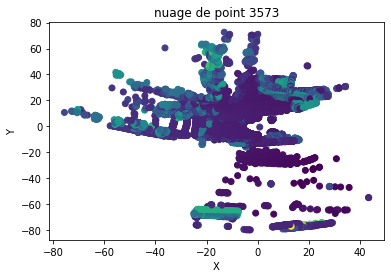

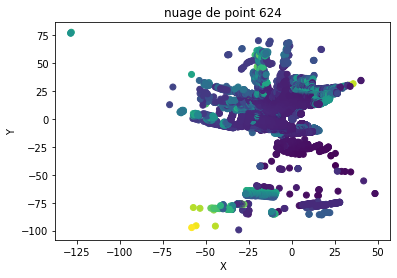

In [8]:
#nuage
og_name = name_dict[query_idx]
if 'Kitti' in cfg.eval_dataset:
    fname = cfg.kitti_dir + 'sequences/'+seq+'/velodyne/'+'%06d' % query_idx + '.bin'

elif 'MulRan' in cfg.eval_dataset:
    fname = '/gpfswork/rech/dki/ujo91el/datas/mulran/'+seq+'/Ouster/'+str(og_name)+'.bin'
print("fname",fname, "query_idx", query_idx)
xyzr = np.fromfile(fname, dtype=np.float32).reshape(-1, 4)
rang = np.linalg.norm(xyzr[:, :3], axis=1)
range_filter = np.logical_and(rang > 0.1, rang < 80)
xyzr = xyzr[range_filter]

#nuage TP
og_name_TP = name_dict[TP_idx]
if 'Kitti' in cfg.eval_dataset:
    fname_TP = cfg.kitti_dir + 'sequences/'+seq+'/velodyne/'+'%06d' % TP_idx + '.bin'

elif 'MulRan' in cfg.eval_dataset:
    fname_TP = '/gpfswork/rech/dki/ujo91el/datas/mulran/'+seq+'/Ouster/'+str(og_name_TP)+'.bin'
print("fname",fname_TP, "query_idx", TP_idx)
xyz_TP = np.fromfile(fname_TP, dtype=np.float32).reshape(-1, 4)
rang_TP = np.linalg.norm(xyz_TP[:, :3], axis=1)
range_filter_TP = np.logical_and(rang > 0.1, rang < 80)
xyz_TP = xyz_TP[range_filter]


plt.figure()
plt.scatter(xyzr[:, 0], xyzr[:, 1], c=xyzr[:, 2])
plt.xlabel("X")
plt.ylabel("Y")
plt.title("nuage de point "+str(query_idx))
plt.show()


plt.figure()
plt.scatter(xyz_TP[:, 0], xyz_TP[:, 1], c=xyz_TP[:, 2])
plt.xlabel("X")
plt.ylabel("Y")
plt.title("nuage de point "+str(TP_idx))
plt.show()

In [9]:
# Get model
model = get_pipeline(cfg.eval_pipeline)

# Get checkpoint, epoch and loss
save_path = os.path.join(os.path.dirname(__file__), '../', 'checkpoints')
save_path = "/gpfswork/rech/dki/ujo91el/code/logg3dnet/resultat/" 
save_path = str(save_path) + cfg.checkpoint_name
print('Loading checkpoint from: ', save_path)
checkpoint = torch.load(save_path)  # ,map_location='cuda:0')
model.load_state_dict(checkpoint['model_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

# model in evaluation mode : normalisation layers use running statistics, de-activates Dropout layers
model = model.cuda()
model.eval()

Loading checkpoint from:  /gpfswork/rech/dki/ujo91el/code/logg3dnet/resultat//logg_epoc_31_mulran


LOGG3D(
  (spvcnn): SPVCNN(
    (stem): Sequential(
      (0): Conv3d(4, 20, kernel_size=(3, 3, 3), bias=False)
      (1): BatchNorm(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv3d(20, 20, kernel_size=(3, 3, 3), bias=False)
      (4): BatchNorm(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
    (stage1): Sequential(
      (0): BasicConvolutionBlock(
        (net): Sequential(
          (0): Conv3d(20, 20, kernel_size=(2, 2, 2), stride=(2, 2, 2), bias=False)
          (1): BatchNorm(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
      )
      (1): ResidualBlock(
        (net): Sequential(
          (0): Conv3d(20, 20, kernel_size=(3, 3, 3), bias=False)
          (1): BatchNorm(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv3d(2

/gpfslocalsup/pub/anaconda-py3/2021.05/envs/pytorch-gpu-1.10.1+py3.9.7/lib/python3.9/site-packages/torchsparse/nn/functional/downsample.py:27: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  coords[:, :3] = coords[:, :3] // sample_stride * sample_stride


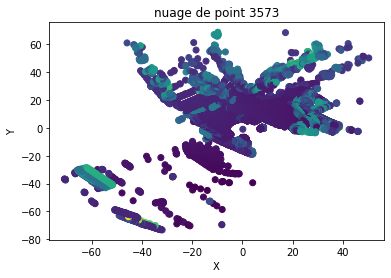

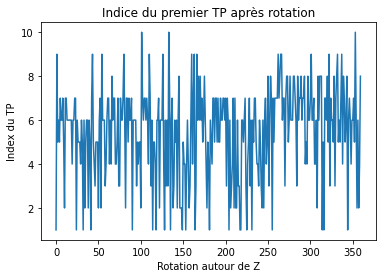

In [10]:
#############################################
#tests
#############################################

if tremblement: 
    index_evolution = []
    for i in range (1, 100):
        i = i/1000
        #Création list des IDs
        list_idx = list(range(len(db_seen_descriptors))) 
         
        xyzbruit = test_bruit(xyzr, i) 
        
        if i == 0.01:
            plt.figure()
            plt.scatter(xyzbruit[:, 0], xyzbruit[:, 1], c=xyzbruit[:, 2])
            plt.xlabel("X")
            plt.ylabel("Y")
            plt.title("nuage de point "+str(query_idx))
 
        input = make_sparse_tensor(xyzbruit, cfg.voxel_size).cuda()

        output_desc, output_feats = model(input)  # .squeeze()

        output_feats = output_feats[0]
        global_descriptor = output_desc.cpu().detach().numpy()
        global_descriptor = np.reshape(global_descriptor, (1, -1))
        db_seen_descriptors2 = db_seen_descriptors.reshape(-1, np.shape(global_descriptor)[1])
        feat_dists = cdist(global_descriptor, db_seen_descriptors2,
                   metric=cfg.eval_feature_distance).reshape(-1)

        feat_dists_copy = list(feat_dists)
        feat_dists_copy, list_idx = zip(*sorted(zip(feat_dists_copy, list_idx)))
        
        index_evolution.append(list_idx.index(TP_idx))
        
        
    plt.figure()
    plt.plot(index_evolution)
    plt.xlabel("n_sigma ")
    plt.ylabel("Index du TP")
    plt.title("Indice du premier TP après bruit")



elif rotation:
    index_evolution = []
    for i in range (360):
        #Création list des IDs
        list_idx = list(range(len(db_seen_descriptors))) 
        """
        if 'MulRan' in cfg.eval_dataset:
            list_file_name = []
            for i in range (len(list_idx[:5])):
                list_file_name.append( name_dict[list_idx[i]] )
            print("list_file_name ",list_file_name)
        """
        
        xyzrot = test_rotation(xyzr, i) 
        
        if i == 45:
            plt.figure()
            plt.scatter(xyzrot[:, 0], xyzrot[:, 1], c=xyzrot[:, 2])
            plt.xlabel("X")
            plt.ylabel("Y")
            plt.title("nuage de point "+str(query_idx))

        input = make_sparse_tensor(xyzrot, cfg.voxel_size).cuda()

        output_desc, output_feats = model(input)  # .squeeze()

        output_feats = output_feats[0]
        global_descriptor = output_desc.cpu().detach().numpy()
        global_descriptor = np.reshape(global_descriptor, (1, -1))
        db_seen_descriptors2 = db_seen_descriptors.reshape(-1, np.shape(global_descriptor)[1])
        feat_dists = cdist(global_descriptor, db_seen_descriptors2,
                   metric=cfg.eval_feature_distance).reshape(-1)

        feat_dists_copy = list(feat_dists)
        feat_dists_copy, list_idx = zip(*sorted(zip(feat_dists_copy, list_idx)))
        
        index_evolution.append(list_idx.index(TP_idx))
        
        
    plt.figure()
    plt.plot(index_evolution)
    plt.xlabel("Rotation autour de Z")
    plt.ylabel("Index du TP")
    plt.title("Indice du premier TP après rotation")

    
elif occlusion:
    print("occultation")
    index_evolution = []
    for i in range (360):
        #Création list des IDs
        list_idx = list(range(len(db_seen_descriptors))) 

        xyzocc = occlude_scan(xyzr, i)
        
        if i == 120:
            plt.figure()
            plt.scatter(xyzocc[:, 0], xyzocc[:, 1], c=xyzocc[:, 2])
            plt.xlabel("X")
            plt.ylabel("Y")
            plt.title("nuage de point "+str(query_idx))

           
        input = make_sparse_tensor(xyzocc, cfg.voxel_size).cuda()

        output_desc, output_feats = model(input)  # .squeeze()

        output_feats = output_feats[0]
        global_descriptor = output_desc.cpu().detach().numpy()
        global_descriptor = np.reshape(global_descriptor, (1, -1))
        db_seen_descriptors2 = db_seen_descriptors.reshape(-1, np.shape(global_descriptor)[1])
        feat_dists = cdist(global_descriptor, db_seen_descriptors2,
                   metric=cfg.eval_feature_distance).reshape(-1)

        feat_dists_copy = list(feat_dists)
        feat_dists_copy, list_idx = zip(*sorted(zip(feat_dists_copy, list_idx)))
        index_evolution.append(list_idx.index(TP_idx))
        
    plt.figure()
    plt.plot(index_evolution)
    plt.xlabel("occultation angulaire ")
    plt.ylabel("Index du TP")
    plt.title("Indice du premier TP après occultation")
